# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [176]:
import pickle, os
import numpy as np
import pandas
import zipfile
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
from skimage import exposure
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy.misc import imresize, imread, imsave
import cv2

import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Visualizations will be shown in the notebook.
%matplotlib inline

---
## Step 0: Load The Data

In [2]:
# TODO: Fill this in based on where you saved the training and testing data
cwd = os.getcwd()
data_dir = '/traffic-signs-data'
training_zipfile = cwd + data_dir + '/train.zip'

if 'train.p' not in os.listdir(cwd+data_dir):
    with zipfile.ZipFile(training_zipfile) as z:
        z.extract('train.p', cwd+data_dir)
    
training_file = cwd + data_dir + '/train.p'
testing_file = cwd + data_dir + '/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_raw, y_train_raw = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_sizes = train['sizes']
X_coords = train['coords']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train_raw)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_raw[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train_raw))

sizes_shape = X_sizes.shape
coords_shape = X_coords.shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("Sizes data shape =", sizes_shape)
print("Coordination data shap =", coords_shape)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Sizes data shape = (39209, 2)
Coordination data shap = (39209, 4)


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Training data:  Speed limit (30km/h)
Test data:  Road narrows on the right


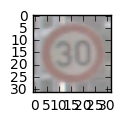

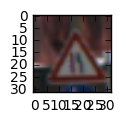

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Get Sign Names from CSV-Table
csv_file = 'signnames.csv'
col_names = ['ClassId', 'SignName']
data = pandas.read_csv(csv_file, names=col_names)
signnames = data.SignName.tolist()
signnames = signnames[1:len(signnames)]

# Get random sign
index = random.randint(0, len(X_train_raw))
image = X_train_raw[index].squeeze()

index1 = random.randint(0, len(X_test))
image1 = X_test[index1].squeeze()

# Plot
plt.figure(figsize=(1,1))
plt.imshow(image)
print("Training data: ", signnames[y_train_raw[index]])

plt.figure(figsize=(1,1))
plt.imshow(image1)
print("Test data: ", signnames[y_test[index1]])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def shuffle_data(X_train_raw, X_sizes, X_coords, y_train_raw):
    X_train_raw, X_sizes, X_coords, y_train_raw = shuffle(X_train_raw, X_sizes, X_coords, y_train_raw)
    return X_train_raw, X_sizes, X_coords, y_train_raw


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

*Randomize the data set before separate them to training and validation sets. The training would be only successful if the data set is random enough since the neural network should not be overfitted to recognize specific data.*



Training data 2887: Speed limit (50km/h)


/home/chili/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


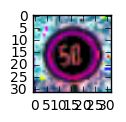

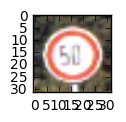

In [160]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
def separate_train_val_test(X_train_raw, X_sizes, X_coords, y_train_raw):
    X_train_raw, X_sizes, X_coords, y_train_raw = shuffle_data(X_train_raw, X_sizes, X_coords, y_train_raw)
    
    n_validation = int(np.ceil(0.2*n_train))
    #print(n_validation, n_train)

    X_validation = X_train_raw[0:n_validation]
    X_train = X_train_raw[n_validation:n_train]
    y_validation = y_train_raw[0:n_validation]
    y_train = y_train_raw[n_validation:n_train]

    #print(X_validation.shape, X_train.shape, y_validation.shape, y_train.shape)
    
    return X_train, y_train, X_validation, y_validation


# Optional: preprocess image to increase contrast on images
def preprocess_image(image, opt='gray'):
    
    if opt == 'gray':
        
        # Apply localized histogram equalization  
        gray = 0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]
        gray = (gray / 255.).astype(np.float64)
        out = (exposure.equalize_adapthist(gray)*255.).astype(np.uint16)
        
    elif opt == 'color':

        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

        # equalize the histogram of the Y channel
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

        # convert the YUV image back to RGB format
        out = cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2BGR)
    
    elif opt == 'combined':
        # Apply localized histogram equalization  
        gray = 0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]
        gray = (gray / 255.).astype(np.float64)
        gray_out = (exposure.equalize_adapthist(gray)*255.).astype(np.uint16)
        gray_out = gray_out.reshape(gray_out.shape[0], gray_out.shape[1], 1)
        
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

        # equalize the histogram of the Y channel
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

        # convert the YUV image back to RGB format
        color_out = cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2BGR)
        
        out = np.concatenate((gray_out, color_out), axis = 2)
        
        out = np.concatenate((out[:,:,0:2], out[:,:,3].reshape(32,32,1) ), axis=2)

    return out

index = random.randint(0, len(X_train_raw))
    
output = preprocess_image(X_train_raw[index], opt='combined')


# Plot
plt.figure(figsize=(1,1))
plt.imshow(output, cmap='gray')
plt.figure(figsize = (1,1))
plt.imshow(X_train_raw[index])
print("Training data " + str(index) + ': ' + signnames[y_train_raw[index]])


In [100]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [161]:


X_train_processed = np.zeros((X_train_raw.shape[0], X_train_raw.shape[1], X_train_raw.shape[2], 3))
X_test_processed = np.zeros((X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))
for i in range(X_train_raw.shape[0]):
    X_train_processed[i] = preprocess_image(X_train_raw[i], opt='combined')
    printProgressBar(i, X_train_raw.shape[0], prefix = 'Progress:', suffix = 'Complete', length = 100)
    
for i in range(X_test.shape[0]):
    X_test_processed[i] = preprocess_image(X_test[i], opt='combined')
    printProgressBar(i, X_test.shape[0], prefix = 'Progress:', suffix = 'Complete', length = 100)
    
#X_train_processed = X_train_processed.reshape((X_train_raw.shape[0], X_train_raw.shape[1], X_train_raw.shape[2],1))
#X_test_processed = X_test_processed.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2],1))


/home/chili/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [162]:
X_train_raw.shape
#X_train_processed.shape

pickle.dump( X_train_processed, open( "X_train_processed.p", "wb" ) )
pickle.dump( X_test_processed, open( "X_test_processed.p", "wb" ) )

with open('X_train_processed.p', mode='rb') as f:
    X_train_processed = pickle.load(f)
with open('X_test_processed.p', mode='rb') as f:
    X_test_processed = pickle.load(f)
    
X_train_processed.shape

(39209, 32, 32, 3)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
*testing data is already separated in test.p so I didn't separated from training data additionally. For the training, I separated training data to training and validation data in a ratio of 80:20*

In [168]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

EPOCHS = 600
BATCH_SIZE = 48

learning_rate = 0.00005

def conv2d(inputs, weights, bias, stride=2, padding='VALID'):
    strides=[1, stride, stride, 1]
    conv = tf.nn.conv2d(inputs, weights, strides, padding)
    out = tf.nn.bias_add(conv, bias)
    return out

def activation(features, opt='relu'):
    if opt == 'relu':
        return tf.nn.relu(features)
    elif opt == 'sigmoid':
        return tf.nn.sigmoid(features)
    elif opt == 'tanh':
        return tf.nn.tanh(features)
        
def maxpool2d(inputs, ksize, stride, padding='VALID'):
    
    ksizes=[1, ksize, ksize, 1]
    strides=[1, stride, stride, 1]
    
    out = tf.nn.max_pool(inputs, ksizes, strides, padding)
    return out

def LeNet(x, dropout_keep_prob):
    mu = 0
    sigma = 0.01

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
    layer1_weights = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 32), mean=mu, stddev=sigma))
    layer1_bias = tf.Variable(tf.zeros(32))
    layer1 = conv2d(x, layer1_weights, layer1_bias, stride=1)

    # Activation.
    layer1 = activation(layer1, opt='relu')

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    pool1 = maxpool2d(layer1, 2, 2)

    # Layer 2: Convolutional. Input = 14x14x32. Output = 10x10x64.
    layer2_weights = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean=mu, stddev=sigma))
    layer2_bias = tf.Variable(tf.zeros(64))
    layer2 = conv2d(pool1, layer2_weights, layer2_bias, stride=1)

    # Activation.2
    layer2 = activation(layer2, opt='relu')
    
    # Pooling. Input = 10x10x64. Output = 5x5x64.
    pool2 = maxpool2d(layer2, 2, 2)

    # Flatten. Input = 5x5x64. Output = 1600.
    fc0 = flatten(pool2)

    # Layer 3: Fully Connected. Input = 1600. Output = 800.
    fc1_weights = tf.Variable(tf.truncated_normal(shape=(1600, 800), mean=mu, stddev=sigma))
    fc1_bias = tf.Variable(tf.zeros(800))
    fc1 = tf.matmul(fc0, fc1_weights) + fc1_bias

    # Activation.
    fc1 = activation(fc1, opt='relu')
    
    fc1_drop = tf.nn.dropout(fc1, dropout_keep_prob+0.1)

    # Layer 4: Fully Connected. Input = 800. Output = 256.
    fc2_weights = tf.Variable(tf.truncated_normal(shape=(800, 256), mean=mu, stddev=sigma))
    fc2_bias = tf.Variable(tf.zeros(256))
    fc2 = tf.matmul(fc1_drop, fc2_weights) + fc2_bias

    # Activation.
    fc2 = activation(fc2, opt='relu')
    
    fc2_drop = tf.nn.dropout(fc2, dropout_keep_prob)

    # Layer 5: Fully Connected. Input = 256. Output = 43.
    fc3_weights = tf.Variable(tf.truncated_normal(shape=(256, 43), mean=mu, stddev=sigma))
    fc3_bias = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2_drop, fc3_weights) + fc3_bias

    return logits, layer1_weights, layer1_bias, layer2_weights, layer2_bias

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
*My final architecture is a LeNet-model with L2-regulization and dropouts in hidden-layers. The LeNet-model has 2 convolutional layers each followed by pooling layers after activation. After convolution, 3 fully connected layers are implemented. I've chosen L2-regulization for the convolutional layers and dropouts for hidden connected layers in order to prevent overfitting. For activations, relu functions are chosen. *


In [169]:
### Train your model here.
### Feel free to use as many code cells as needed.

def optimize(eta = 0.001, opt='Adam'):
    if opt == 'Adam':
        return tf.train.AdamOptimizer(learning_rate=eta)
    elif opt == 'Adagrad':
        return tf.train.AdagradOptimizer(learning_rate=eta)
    elif opt == 'Momentum':
        return tf.train.MomentumOptimizer(learning_rate=eta)
    elif opt == 'AdagradDA':
        return tf.train.AdagradDAOptimizer(learning_rate=eta)
    elif opt == 'Adadelta':
        return tf.train.AdadeltaOptimizer(learning_rate=eta)
    elif opt == 'GradientDescent':
        return tf.train.GradientDescentOptimizer(learning_rate=eta)
    
image_shape = X_train_processed[0].shape
x = tf.placeholder(tf.float32, (None,) + image_shape)
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

# LeNet
logits, hidden_weights_1, hidden_bias_1, hidden_weights_2, hidden_bias_2 = LeNet(x, keep_prob)

# Loss 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)

beta = 0.0001
l2_reg_weights_1 = beta*tf.nn.l2_loss(hidden_weights_1)
l2_reg_bias_1 = beta*tf.nn.l2_loss(hidden_bias_1)
l2_reg_weights_2 = beta*tf.nn.l2_loss(hidden_weights_2)
l2_reg_bias_2 = beta*tf.nn.l2_loss(hidden_bias_2)

loss_operation = tf.reduce_mean(cross_entropy + \
                                l2_reg_weights_1 + l2_reg_bias_1 + l2_reg_weights_2 + l2_reg_bias_2)

# Optimize: Adam
optimizer = optimize(eta = learning_rate, opt='Adam')
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        kb = 1
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:kb})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [170]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    
    ep = np.array([])
    v_acc = np.array([])
    t_acc = np.array([])
    
    print("Training...")
    print()
    test_accuracy = 0
    best_try = 0
    i = 0
    while (i < EPOCHS and test_accuracy < 0.98):
        X_train, y_train, X_validation, y_validation = separate_train_val_test(X_train_processed, X_sizes, X_coords, y_train_raw)
        num_examples = len(X_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            kb = 0.8
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:kb})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        test_accuracy = evaluate(X_test_processed, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.5f}".format(validation_accuracy))
        print("Test Accuracy = {:.5f}".format(test_accuracy))
        print()
        
        ep = np.append(ep, i+1)
        v_acc = np.append(v_acc, validation_accuracy)
        t_acc = np.append(t_acc, test_accuracy)
        i = i+1
        
        if test_accuracy>best_try:
            best_try = test_accuracy
            saver.save(sess, cwd+'/lenet')
            print("Model saved")
    
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.79291
Test Accuracy = 0.73302

Model saved
EPOCH 2 ...
Validation Accuracy = 0.89582
Test Accuracy = 0.85416

Model saved
EPOCH 3 ...
Validation Accuracy = 0.94402
Test Accuracy = 0.88860

Model saved
EPOCH 4 ...
Validation Accuracy = 0.96047
Test Accuracy = 0.91489

Model saved
EPOCH 5 ...
Validation Accuracy = 0.97539
Test Accuracy = 0.92692

Model saved
EPOCH 6 ...
Validation Accuracy = 0.98687
Test Accuracy = 0.93238

Model saved
EPOCH 7 ...
Validation Accuracy = 0.98444
Test Accuracy = 0.93072

EPOCH 8 ...
Validation Accuracy = 0.99056
Test Accuracy = 0.93286

Model saved
EPOCH 9 ...
Validation Accuracy = 0.99120
Test Accuracy = 0.93278

EPOCH 10 ...
Validation Accuracy = 0.99337
Test Accuracy = 0.94378

Model saved
EPOCH 11 ...
Validation Accuracy = 0.99095
Test Accuracy = 0.93856

EPOCH 12 ...
Validation Accuracy = 0.99477
Test Accuracy = 0.94283

EPOCH 13 ...
Validation Accuracy = 0.99758
Test Accuracy = 0.95289

Model saved
EPOC

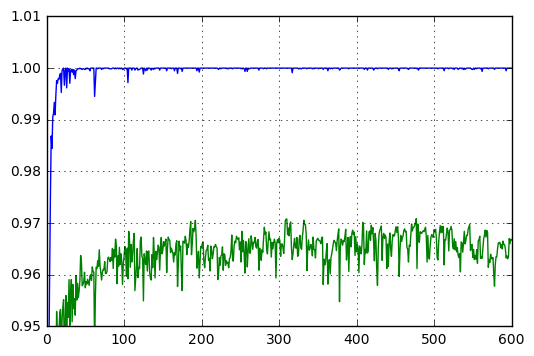

In [173]:
plt.figure()
plt.plot(ep, v_acc)
plt.plot(ep, t_acc)
plt.ylim([0.95, 1.01])
plt.grid()


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

- *Optimizer: I use AdamOptimizer as default optimizer, I've also tried other optimizer tensorflow provided, e.g. AdaGrad, GradientDescent, but Adam works best in this case.*
- *Batch Size: I tried 48, 64, 128 and 256. It seems that 256 works the worst and 48, 64 and 128 are doing better. *
- *Epochs: I've tried up to 2000 epochs. It seems that the CNN can be trained up to 1000 epochs but the best parameters could already be achieved after 200 epochs. *
- *Learning Rate: I've tried varius value between 1e-5 and 1e-4. With higher learning rate, the CNN tend to be overfitted earlier. *
- *L2-Regulization Rate: beta is set to 1e-4. *
- *Keep Probabiltiy of Dropouts: keep probability is set to 0.9 and 0.8, it could also be lower, both worked fine for this task.*

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

*I use a lenet-model as a starting point for this task since it contains convolutional layers which specifically suits the task of image recognition. The first try with original images without preprocessing results an accuracy on testing set of ca. 94%. 
I've added L2-regulization and dropouts to the hidden layers to prevent overfitting and preprocessed the image with grayscale and histogram equalizer. This helped me to improve the accuracy to ca. 96%. 
In order to improve this result, I've preprosess my image with colored histogram equalizer and mixed red and blue channel with grayscale image. It seems that this mix contains the most usefull information to train the CNN and I've archieved 97,165% testing accuracy.*

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

test11.jpg
test10.jpg
test05.jpg
test03.jpg
test12.jpg
test04.jpg
test09.jpg
test01.jpg
test08.jpg
test07.jpg
test02.jpg
test06.jpg


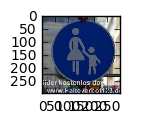

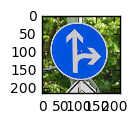

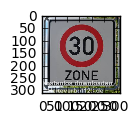

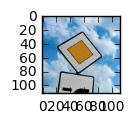

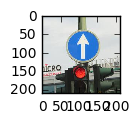

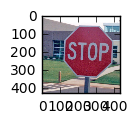

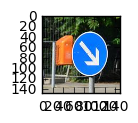

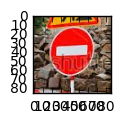

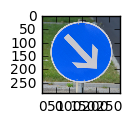

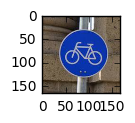

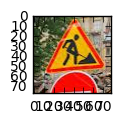

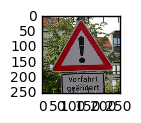

In [179]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def resize(image, width=32, height=32):

    image_resized = imresize(image, (width, width))
    
    return image_resized
    
folder_testimages = '/traffic-signs-data/test_images'
all_image_files = os.listdir(cwd + folder_testimages)

all_image_files = [fn for fn in os.listdir(cwd + folder_testimages)
              if fn.endswith('jpg')]

try:
    os.stat(cwd + folder_testimages + '/resized/')
except:
    os.mkdir(cwd + folder_testimages + '/resized/')  

for image_file in all_image_files:
    img = imread(cwd + folder_testimages + '/' + image_file)
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    img = resize(img)
    print(image_file)
    
    imsave(cwd + folder_testimages + '/resized/' + image_file, img)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

*test02 might be difficult since the training-set contains only signs with white background, test07 and test11 are unknown signs, so it is expected that the CNN recognize nothing. test12 is quite challenging since the sign relatively small. test09 is challenging because of the view angle. *

In [183]:
### Run the predictions here.
### Feel free to use as many code cells as needed
with tf.Session() as sess:
  
    saver.restore(sess, cwd+"/lenet")
    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.5f}".format(test_accuracy))

    

Test Accuracy = 0.97165


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.